In [51]:
###################
# Pick An Example #
###################

#[Input Vars]
#  1. <int> i: the index of the training dataset
#  2. <dataframe> DF_TRAIN: Dataframe-like format
#
#[Output Vars]
#  1. <ndarray> X: Image
#  2. <ndarray> Y: The label to the image

import numpy as np

def pick_an_example(i, DF_TRAIN):
    X = DF_TRAIN[i:i+1].values[0][1:].reshape(28,28,1)
    Y = DF_TRAIN[i:i+1].values[0][0]
    return X, Y

#i = np.random.randint(len(DF_TRAIN))
#X, Y = pick_an_example(i, DF_TRAIN)
#print(f"The Label of the {i}-th example is {Y}\nThe corresponding data is at below.")
#plt.imshow(X, cmap=plt.get_cmap('gray'))
#plt.show()

In [52]:
################
# Zero Padding #
################

#[Input Vars]
#  1. <ndarray> X: Unpadded image. The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <int> pad: expected number of pads on each side. The shape is (n_H_prev + 2 * pad, n_W_prev + 2 * pad, n_C_prev).
#
#[Output Vars]
#  1. <ndarray> X_pad: Padded image.

import numpy as np

def __zero_pad(X, pad):
    X_pad = np.pad(X, ((pad, pad), (pad, pad),(0,0)), "constant", constant_values = 0)
    return X_pad

In [53]:
####################
# Conv Single Step #
####################

#[Input Vars]
#  1. <ndarray> a_slice_prev: slice of previous feature maps. The shape is (f, f, n_C_prev).
#  2. <ndarray> K: A single weight matrix (kernel). The shape is (f, f, n_C_prev).
#  3. <ndarray> b: A single bias term. The shape is (1, 1, 1).
#
#[Output Vars]
#  1. <float> Z: a scalar derived from convolution operation.

import numpy as np

def __conv_single_step(s_slice, K, b):
    
    S = np.multiply(s_slice, K)
    Z = np.sum(S)
    Z = Z + float(b)
    
    return Z

In [54]:
############################
# Conv Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> S_prev: The previous feature maps (after activation and pooling). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> K: Kernels in a layer. The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> b: biases in a layer. THe shape is (1, 1, 1, n_C).
#  4. <dictionary> hparam: this contains hyper parameters like "pad" and "stride".
#
#[Output Vars]
#  1. <ndarray> C: This would be the feature map in the next layer (but before activation). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache the values needed for backward propagation.

import numpy as np

def conv_forward(S_prev, K, b, hparam):
    
    # 1. Retrieve shape of A_prev. We need this to compute the shape of the feature map in the next layer.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 2. Retrieve shape of K. We also need this (i.e. f) to compute the shape of the feature map in the next layer.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 3. Retrieve info. from hyper parameters. We need them to compute the shape of the feature map in the next layer, too.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 4. With info from 1. ~ 3., we can compute the dimension for the feature map in the next layer.
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # 5. Initialize feature maps in the next layer with zeros. Note #Kernel is equal to #Channel of the feature map.
    C = np.zeros((n_H, n_W, n_C))
    
    # 6. Pad S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    
    # 7. Do Cross-Relation Operation. Note the shape of the output feature map would be (n_H, n_W, n_C).
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the S_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Feed it into __conv_single_step(a_slice, K, b). Note we use one kernel and one bias term at once.
                C[h, w, c] = __conv_single_step(S_prev_slice, K[:,:,:,c], b[:,:,:,c])
    
    # 8. Check if the output feature map have the valid shape.
    assert(C.shape == (n_H, n_W, n_C))
    
    # 9. Store the cache for backward propagation
    cache = (S_prev, K, b, hparam)
    
    return C, cache

In [55]:
############################
# Pool Forward Propagation #
############################

#[Input Vars]
#  1. <ndarray> A_prev: The previous feature maps (after activation). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <dictionary> hparam: It contains "f" and "stride".
#  3. <string> mode: Switch between "maxpooling" and "avgpooling". The shape is (n_H, n_W, n_C). (n_C = n_C_prev)
#
#[Output Vars]
#  1. <ndarray> S: The output feature map after pooling operation.

import numpy as np

def pool_forward(A_prev, hparam, mode = "maxpooling"):
    # 1. Retrieve shape of A_prev.
    (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # 2. Retrieve info from hyper parameter
    f = hparam["f"]
    stride = hparam["stride"]

    # 3. Define the shape of output of pooling operation.
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # 4. Initialize the output feature map after pooling operation with zeros.
    S = np.zeros((n_H, n_W, n_C))
    
    # 5. Do Pooling Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Get the slice. (Note that there's only one channel involved. Not like conv_forward)
                A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                
                # Pooling operation
                if mode == "maxpooling":
                    S[h, w, c] = np.max(A_prev_slice)
                elif mode == "avgpooling":
                    S[h, w, c] = np.mean(A_prev_slice)
                    
    # 6. Check if the output feature map have the valid shape.
    assert(S.shape == (n_H, n_W, n_C))
    
    # 7. Store the cache for backward propagation
    cache = (A_prev, hparam)
    
    return S, cache

In [56]:
#############################
# Conv Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dC: gradient of the cost with respect to the output of the conv layer (C). The shape is (n_H, n_W, n_C).
#  2. <dictionary> cache: Cache of output of conv_forward()
#
#[Output Vars]
#  1. <ndarray> dS_prev: gradient of the cost w.r.t. the input of the conv layer (S). The shape is (n_H_prev, n_W_prev, n_C_prev).
#  2. <ndarray> dK: gradient of the cost w.r.t. the weights of the conv layer (K). The shape is (f, f, n_C_prev, n_C).
#  3. <ndarray> db: gradient of the cost w.r.t. the biases of the conv layer (b). The shape is (1, 1, 1, n_C).

def conv_backward(dC, cache):
    
    # 1. Retrieve info. from cache.
    (S_prev, K, b, hparam) = cache
    
    # 2. Retrieve the shape of S_prev.
    (n_H_prev, n_W_prev, n_C_prev) = S_prev.shape
    
    # 3. Retrieve the shape of Kernel.
    (f, f, n_C_prev, n_C) = K.shape
    
    # 4. Retieve info. from hyper parameters.
    stride = hparam["stride"]
    pad = hparam["pad"]
    
    # 5. Retrieve the shape of dC
    (n_H, n_W, n_C) = dC.shape
    
    # 6. Initialize dS_prev, dK, db with the correct shapes.
    dS_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    dK = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    # 7. Pad dS_prev and S_prev
    S_prev_pad = __zero_pad(S_prev, pad)
    dS_prev_pad = __zero_pad(dS_prev, pad)
    
    # 8. Do backward pass operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                    
                # Get the slice.
                S_prev_slice = S_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :]
                
                # Update Gradients (dS_prev, dK, db) for the window
                dS_prev_pad[vert_head:vert_tail, hori_head:hori_tail, :] += K[:,:,:,c] * dC[h, w, c]
                dK[: , :, :, c] += S_prev_slice * dC[h, w, c]
                db[: , :, :, c] += dC[h, w, c]
                
    # 9. Unpad dS_prev_pad
    if (pad == 0):
        dS_prev = dS_prev_pad
    else:
        dS_prev[:, :, :] = dS_prev_pad[pad:-pad, pad:-pad, :]
    
    
    # 10 Check the validity of the shape
    assert (dS_prev.shape == (n_H_prev, n_W_prev, n_C_prev))
    
    return dS_prev, dK, db

In [57]:
############################
# Max Pool Backward helper #
############################

import numpy as np

def __create_mask_from_window(s):
    mask = (s == np.max(s))
    return mask

############################
# Avg Pool Backward helper #
############################

def __distribute_value(ds, shape):
    
    # 1. Retrieve dimensions from shape
    (n_H, n_W) = shape
    
    # 2. Compute the value to distribute on the matrix
    average = ds / (n_H * n_W)
    
    # 3. Create a matrix where each entry is the avg. value.
    a = np.ones(shape) * average
    return a

In [58]:
#############################
# Pool Backward Propagation #
#############################

#[Input Vars]
#  1. <ndarray> dS: gradient of cost w.r.t. the output of the pooling layer. The shape is the same as the shape of S.
#  2. <dictionary> cache: It contaions the output from the forward pass.
#  3. <string> mode: Switch between "maxpooling" and "avgpooling".
#
#[Output Vars]
#  1. <ndarray> dA_prev: gradient of cost w.r.t. the input of the pooling layer. The shape is the same as the shape of A_prev.

import numpy as np

def pool_backward(dS, cache, mode = "maxpooling"):
    
    # 1. Retrieve info. from cache
    (A_prev, hparam) = cache
    
    # 2. Retrieve hyper parameters
    stride = hparam["stride"]
    f = hparam["f"]
    
    # 3. Retrieve the shapes of A_prev and dS
    n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    n_H, n_W, n_C = dS.shape
    
    # 4. Initialize dA_prev with zeros.
    dA_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))
    
    # 5. Do Backward Pass Operation
    for h in range(n_H):
        for w in range(n_W):
            for c in range(n_C):
                                
                # Define the corners in the A_prev_pad.
                vert_head = h * stride
                vert_tail = vert_head + f
                hori_head = w * stride
                hori_tail = hori_head + f
                
                # Compute the backward propagation in both modes
                if mode == "maxpooling":
                    # Use the corners and the specific "c" tp defome the current slice of A_prev
                    A_prev_slice = A_prev[vert_head:vert_tail, hori_head:hori_tail, c]
                    
                    # Create the mask from A_prev_slice
                    mask = __create_mask_from_window(A_prev_slice)
                    
                    # Update dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += np.multiply(mask, dS[h, w, c])
                elif mode == "avgpooling":
                    # Get the entry ds from dS
                    ds = dS[h, w, c]
                    
                    # Define the shape of the kernel as (f, f).
                    shape = (f, f)
                    
                    # Distribute it (ds) to the correct slice of dA_prev
                    dA_prev[vert_head:vert_tail, hori_head:hori_tail, c] += __distribute_value(ds, shape)
    
    # 6. Check the dA_prev has the valid shape 
    assert (dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [59]:
########################################
# Actication Functions for Propagation #
########################################

# [Input Vars]
#   1. <ndarray> Z
#
# [Output Vars]
#   1. <ndarray> A

import numpy as np

def activation_forward(Z, mode):
    if mode == "sigmoid":
        A = 1/(1 + np.exp(-Z))
    elif mode == "relu":
        A = Z * (Z > 0)
    return A

def activation_backward(X, mode):
    if mode == "sigmoid":
        D_Z_local = np.multiply(1 - X, X)
    elif mode == "relu":
        D_Z_local = X
        D_Z_local[X<=0] = 0
        D_Z_local[X>0] = 1
    return D_Z_local

# [Input Vars]
#   1. <ndarray> A
#
# [Output Vars]
#   1. <ndarray> Y_pred
def __softmax(A):
    Y_pred = np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)))
    return Y_pred

In [60]:
# Initiallize the Kernels, Biases, and hparams

def Initialize_Parameters(low, high):
    
    # C1
    K_C1 = np.random.uniform(low=low, high=high, size=(5, 5, 1, 6))
    b_C1 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 6))
    hparam_C1 = {"stride": 1, "pad": 2}

    # S2
    hparam_S2 = {"f": 2, "stride": 2}

    # C3
    K_C3 = np.random.uniform(low=low, high=high, size=(5, 5, 6, 16))
    b_C3 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 16))
    hparam_C3 = {"stride":1, "pad": 0}

    # S4
    hparam_S4 = {"f": 2, "stride": 2}

    # C5
    K_C5 = np.random.uniform(low=low, high=high, size=(5, 5, 16, 120))
    b_C5 = np.random.uniform(low=low, high=high, size=(1, 1, 1, 120))
    hparam_C5 = {"stride":1, "pad": 0}

    # W7
    W7 = np.random.uniform(low=low, high=high, size=(120, 84))

    # W8
    W8 = np.random.uniform(low=low, high=high, size=(84, 10))
    
    return K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8

In [61]:

# LeNet5 - Forward Propagation

def LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, pool_mode = "avgpooling", act_mode = "sigmoid"):
    
    X_C1, cache_C1 = conv_forward(X, K_C1, b_C1, hparam_C1)
    X_A1 = activation_forward(X_C1, act_mode)
    X_S2, cache_S2 = pool_forward(X_A1, hparam_S2, pool_mode)
    X_C3, cache_C3 = conv_forward(X_S2, K_C3, b_C3, hparam_C3)
    X_A3 = activation_forward(X_C3, act_mode)
    X_S4, cache_S4 = pool_forward(X_A3, hparam_S4, pool_mode)
    X_C5, cache_C5 = conv_forward(X_S4, K_C5, b_C5, hparam_C5)
    X_A5 = activation_forward(X_C5, act_mode)
    X_A6 = X_A5.reshape(1, 120)
    X_Z7 = np.dot(X_A6, W7)
    X_A7 = activation_forward(X_Z7, act_mode)
    X_Z8 = np.dot(X_A7, W8)
    #X_A8 = activation_forward(X_Z8, act_mode)
    #Y_pred = __softmax(X_A8)
    Y_pred = __softmax(X_Z8)
    
    #return cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred
    return cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, Y_pred

In [62]:
def cross_entropy(Y_pred, Y_truth):
    Error = (-1 * Y_truth * np.log(Y_pred)).sum()
    return Error

In [63]:
# LeNet5 - Backward Propagation
#def LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth, pool_mode = "avgpooling", act_mode = "sigmoid"):
def LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, Y_pred, Y_truth, pool_mode = "avgpooling", act_mode = "sigmoid"):
    #D_A8 = Y_pred - Y_truth
    
    #D_Z8_local = activation_backward(X_A8, act_mode)
    
    #D_Z8 = np.multiply(D_Z8_local, D_A8)
    
    D_Z8 = Y_pred - Y_truth
    
    D_W8 = np.outer(X_A7, D_Z8)
    
    D_A7 = np.dot(D_Z8, D_W8.T)
    
    D_Z7_local = activation_backward(X_A7, act_mode)
    
    D_Z7 = np.multiply(D_Z7_local, D_A7)
    
    D_W7 = np.outer(X_A6, D_Z7)
    
    D_A6 = np.dot(D_Z7, D_W7.T)
    
    D_A5 = D_A6.reshape(1,1,120)
    
    D_C5_local = activation_backward(X_A5, act_mode)
    
    D_C5 = np.multiply(D_C5_local, D_A5)
    
    D_S4, D_K_C5, D_b_C5 = conv_backward(D_C5, cache_C5)
    
    D_A3 = pool_backward(D_S4, cache_S4, pool_mode)
    
    D_C3_local = activation_backward(X_A3, act_mode)
    
    D_C3 = np.multiply(D_C3_local, D_A3)
    
    D_S2, D_K_C3, D_b_C3 = conv_backward(D_C3, cache_C3)
    
    D_A1 = pool_backward(D_S2, cache_S2, pool_mode)
    
    D_C1_local = activation_backward(X_A1, act_mode)
    
    D_C1 = np.multiply(D_C1_local, D_A1)
    
    D_X, D_K_C1, D_b_C1 = conv_backward(D_C1, cache_C1)
    
    return D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1

In [64]:
def update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1):
    
    W8 = W8 - lr * D_W8
    W7 = W7 - lr * D_W7
    K_C5 = K_C5 - lr * D_K_C5
    b_C5 = b_C5 - lr * D_b_C5
    K_C3 = K_C3 - lr * D_K_C3
    b_C3 = b_C3 - lr * D_b_C3
    K_C1 = K_C1 - lr * D_K_C1
    b_C1 = b_C1 - lr * D_b_C1
    
    return W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1

In [65]:
tmp = np.zeros(10)
tmp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [66]:
import pickle
from tqdm import tqdm

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

X_train_tmp, Y_train_tmp, X_test_tmp, Y_test_tmp = load()

X_train = np.zeros((len(X_train_tmp), 28, 28, 1))
Y_train = np.zeros((len(Y_train_tmp), 10))

for i in tqdm(range(len(Y_train_tmp))):
    x_tmp = X_train_tmp[i].reshape(28,28,1)
    x_tmp = x_tmp/255.
    X_train[i] = x_tmp
    
    y_tmp = np.zeros(10)
    y_tmp[Y_train_tmp[i]] = 1
    
    Y_train[i] = y_tmp    

100%|█████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 85828.46it/s]


  0%|                                                                                 | 1/5000 [00:00<23:13,  3.59it/s]

[2.470284]
[[[0.07842466 0.10785877 0.12294245 0.13952462 0.12097114 0.08456084
  0.07344366 0.08625788 0.10991837 0.07609762]]]


  2%|█▌                                                                             | 101/5000 [00:31<20:46,  3.93it/s]

[20.697134]
[[[1.00251261e-09 9.99999992e-01 6.07770409e-10 5.21087743e-10
  6.76424080e-10 1.02647618e-09 1.19907554e-09 1.02260800e-09
  7.44705595e-10 1.04161533e-09]]]


  4%|███▏                                                                           | 201/5000 [00:59<21:52,  3.66it/s]

[20.672495]
[[[1.31977638e-09 1.05208170e-09 9.99999989e-01 6.85829500e-10
  8.90517307e-10 1.35176623e-09 1.57860526e-09 1.34644804e-09
  9.80711422e-10 1.37196712e-09]]]


  6%|████▊                                                                          | 301/5000 [01:31<22:38,  3.46it/s]

[21.420791]
[[[6.69850610e-10 5.34363143e-10 4.06056599e-10 3.48055612e-10
  4.51958313e-10 6.86068013e-10 9.99999995e-01 6.83680385e-10
  4.97816025e-10 6.96636724e-10]]]


  8%|██████▎                                                                        | 401/5000 [02:00<21:48,  3.51it/s]

[21.44463]
[[[9.99999994e-01 6.40358988e-10 4.86088913e-10 4.16890116e-10
  5.41484139e-10 8.21859810e-10 9.59665181e-10 8.19149933e-10
  5.96124811e-10 8.34632650e-10]]]


 10%|███████▉                                                                       | 501/5000 [02:31<21:07,  3.55it/s]

[21.300622]
[[[1.07960252e-09 8.62871921e-10 6.54752233e-10 5.61380446e-10
  7.29322129e-10 1.10700924e-09 1.29224151e-09 1.10318209e-09
  9.99999991e-01 1.12424812e-09]]]


 12%|█████████▍                                                                     | 601/5000 [02:58<19:19,  3.80it/s]

[20.923254]
[[[7.86012181e-10 6.28567673e-10 4.76698695e-10 4.08779443e-10
  5.31231416e-10 8.06196237e-10 9.40873474e-10 9.99999994e-01
  5.84476478e-10 8.18740252e-10]]]


 14%|███████████                                                                    | 701/5000 [03:26<18:15,  3.92it/s]

[21.358249]
[[[7.83921219e-10 6.27359384e-10 4.75605499e-10 4.07638749e-10
  5.29944346e-10 9.99999994e-01 9.38424787e-10 8.01738929e-10
  5.83132029e-10 8.16790008e-10]]]


 16%|████████████▋                                                                  | 801/5000 [03:52<17:29,  4.00it/s]

[20.924932]
[[[7.84147867e-10 6.27968633e-10 4.75883801e-10 4.07902466e-10
  5.30361227e-10 9.99999994e-01 9.38810363e-10 8.02485294e-10
  5.83587411e-10 8.17368125e-10]]]


 18%|██████████████▏                                                                | 901/5000 [04:20<17:50,  3.83it/s]

[20.924295]
[[[7.84444120e-10 6.28390039e-10 4.76088587e-10 4.08064208e-10
  5.30606031e-10 9.99999994e-01 9.39357200e-10 8.03126750e-10
  5.83906193e-10 8.17888601e-10]]]


 20%|███████████████▌                                                              | 1001/5000 [04:45<16:44,  3.98it/s]

[21.119896]
[[[6.72582782e-10 5.39008502e-10 4.08175368e-10 3.49864856e-10
  4.54957378e-10 6.90317029e-10 9.99999995e-01 6.88703623e-10
  5.00702597e-10 7.01361699e-10]]]


 22%|█████████████████▏                                                            | 1101/5000 [05:10<16:02,  4.05it/s]

[20.368021]
[[[1.19143000e-09 9.55092861e-10 7.22945763e-10 6.19650076e-10
  9.99999991e-01 1.22272588e-09 1.42652982e-09 1.21995044e-09
  8.86823395e-10 1.24226386e-09]]]


 24%|██████████████████▋                                                           | 1201/5000 [05:38<16:04,  3.94it/s]

[20.659946]
[[[1.32865506e-09 1.06536789e-09 9.99999989e-01 6.90990272e-10
  8.98609232e-10 1.36355756e-09 1.59103637e-09 1.36068960e-09
  9.88968144e-10 1.38525891e-09]]]


 26%|████████████████████▎                                                         | 1301/5000 [06:03<15:47,  3.91it/s]

[20.414647]
[[[1.32942143e-09 1.06630437e-09 9.99999989e-01 6.91292941e-10
  8.98972845e-10 1.36457068e-09 1.59210606e-09 1.36154307e-09
  9.89438792e-10 1.38623620e-09]]]


 28%|█████████████████████▊                                                        | 1401/5000 [06:31<14:59,  4.00it/s]

[20.955593]
[[[7.73499853e-10 6.20649690e-10 4.69292435e-10 4.02301418e-10
  5.23172715e-10 7.94192643e-10 9.26553350e-10 7.92686614e-10
  5.75843384e-10 9.99999994e-01]]]


 30%|███████████████████████▍                                                      | 1501/5000 [06:56<14:29,  4.03it/s]

[20.919724]
[[[7.87351451e-10 6.32017426e-10 4.77809527e-10 4.09563444e-10
  5.32649120e-10 8.08620752e-10 9.43348964e-10 9.99999994e-01
  5.86319200e-10 8.21635745e-10]]]


 32%|████████████████████████▉                                                     | 1601/5000 [07:24<14:16,  3.97it/s]

[20.283773]
[[[1.55192031e-09 1.24617482e-09 9.41982629e-10 9.99999987e-01
  1.04994703e-09 1.59417059e-09 1.86008861e-09 1.59129336e-09
  1.15575060e-09 1.61990807e-09]]]


 34%|██████████████████████████▌                                                   | 1701/5000 [07:49<13:47,  3.99it/s]

[0.0]
[[[1.00536714e-09 9.99999992e-01 6.10266581e-10 5.23058373e-10
  6.80125132e-10 1.03296040e-09 1.20530979e-09 1.03103073e-09
  7.48808996e-10 1.04951419e-09]]]


 36%|████████████████████████████                                                  | 1801/5000 [08:17<18:10,  2.93it/s]

[20.782427]
[[[1.55265274e-09 1.24769428e-09 9.42554574e-10 9.99999987e-01
  1.05064816e-09 1.59547001e-09 1.86172688e-09 1.59276922e-09
  1.15666123e-09 1.62117225e-09]]]


 38%|█████████████████████████████▋                                                | 1901/5000 [08:43<13:02,  3.96it/s]

[21.461143]
[[[7.87568698e-10 6.33048528e-10 4.78127778e-10 4.09864303e-10
  5.32952074e-10 8.09473672e-10 9.44474269e-10 9.99999994e-01
  5.86769811e-10 8.22409957e-10]]]


 40%|███████████████████████████████▏                                              | 2001/5000 [09:08<12:43,  3.93it/s]

[20.908168]
[[[9.99999994e-01 6.50055463e-10 4.90928097e-10 4.20796757e-10
  5.47224732e-10 8.31185518e-10 9.69883984e-10 8.29822928e-10
  6.02433942e-10 8.44548869e-10]]]


 42%|████████████████████████████████▊                                             | 2101/5000 [09:36<11:55,  4.05it/s]

[20.97973]
[[[7.73782646e-10 6.22457529e-10 4.69913051e-10 4.02843549e-10
  5.23885090e-10 7.95748643e-10 9.28581500e-10 7.94432115e-10
  5.76793964e-10 9.99999994e-01]]]


 44%|██████████████████████████████████▎                                           | 2201/5000 [10:01<12:15,  3.80it/s]

[21.632246]
[[[7.73896755e-10 6.22823088e-10 4.70047151e-10 4.02934876e-10
  5.24007790e-10 7.95957220e-10 9.28766329e-10 7.94645916e-10
  5.76956701e-10 9.99999994e-01]]]


 46%|███████████████████████████████████▉                                          | 2301/5000 [10:29<11:16,  3.99it/s]

[20.79701]
[[[7.73975043e-10 6.23043755e-10 4.70051588e-10 4.03068119e-10
  5.24105055e-10 7.96198924e-10 9.28909751e-10 7.94844583e-10
  5.77027594e-10 9.99999994e-01]]]


 48%|█████████████████████████████████████▍                                        | 2401/5000 [10:54<10:58,  3.95it/s]

[20.729706]
[[[1.33246454e-09 1.07298685e-09 9.99999989e-01 6.93986509e-10
  9.02338254e-10 1.37106275e-09 1.59937445e-09 1.36870321e-09
  9.93580862e-10 1.39310905e-09]]]


 50%|███████████████████████████████████████                                       | 2501/5000 [11:22<10:24,  4.00it/s]

[20.436021]
[[[1.33275090e-09 1.07341331e-09 9.99999989e-01 6.94171701e-10
  9.02525742e-10 1.37145549e-09 1.59982264e-09 1.36922078e-09
  9.93881540e-10 1.39363375e-09]]]


 52%|████████████████████████████████████████▌                                     | 2601/5000 [11:47<10:04,  3.97it/s]

[20.673425]
[[[1.00501915e-09 9.99999992e-01 6.10318279e-10 5.23520720e-10
  6.80601799e-10 1.03425242e-09 1.20649505e-09 1.03270207e-09
  7.49470440e-10 1.05110404e-09]]]


 54%|██████████████████████████████████████████▏                                   | 2701/5000 [12:13<15:54,  2.41it/s]

[21.139811]
[[[1.08584066e-09 8.74872336e-10 6.59320867e-10 5.65597908e-10
  7.35303579e-10 1.11753317e-09 1.30366594e-09 1.11571252e-09
  9.99999991e-01 1.13579082e-09]]]


 56%|███████████████████████████████████████████▋                                  | 2801/5000 [12:40<09:13,  3.98it/s]

[0.0]
[[[1.19610314e-09 9.63999286e-10 7.26213234e-10 6.23106827e-10
  9.99999990e-01 1.23118303e-09 1.43602908e-09 1.22920479e-09
  8.92044866e-10 1.25118158e-09]]]


 58%|█████████████████████████████████████████████▎                                | 2901/5000 [13:06<08:41,  4.03it/s]

[20.905052]
[[[9.99999994e-01 6.52979556e-10 4.91710806e-10 4.21954019e-10
  5.48407644e-10 8.33779228e-10 9.72470976e-10 8.32541045e-10
  6.04079529e-10 8.47296740e-10]]]


 60%|██████████████████████████████████████████████▊                               | 3001/5000 [13:34<08:31,  3.90it/s]

[20.917595]
[[[7.87130311e-10 6.34626091e-10 4.77794453e-10 4.10029461e-10
  5.32896404e-10 9.99999994e-01 9.45051600e-10 8.09059261e-10
  5.86998497e-10 8.23386748e-10]]]


 62%|████████████████████████████████████████████████▍                             | 3101/5000 [13:59<08:08,  3.89it/s]

[21.368676]
[[[7.74610861e-10 6.24572798e-10 4.70171147e-10 4.03517901e-10
  5.24447138e-10 7.97416892e-10 9.30119558e-10 7.96267978e-10
  5.77677098e-10 9.99999994e-01]]]


 64%|█████████████████████████████████████████████████▉                            | 3201/5000 [14:27<07:27,  4.02it/s]

[0.0]
[[[1.33534345e-09 1.07689729e-09 9.99999989e-01 6.95685853e-10
  9.04096490e-10 1.37487916e-09 1.60365041e-09 1.37278059e-09
  9.95935749e-10 1.39718521e-09]]]


 66%|███████████████████████████████████████████████████▍                          | 3301/5000 [14:52<07:01,  4.03it/s]

[21.13918]
[[[1.08682421e-09 8.76652614e-10 6.59736964e-10 5.66244985e-10
  7.35904812e-10 1.11907435e-09 1.30533519e-09 1.11749898e-09
  9.99999991e-01 1.13729147e-09]]]


 68%|█████████████████████████████████████████████████████                         | 3401/5000 [15:20<06:42,  3.97it/s]

[21.19503]
[[[1.19752530e-09 9.66056748e-10 7.26835652e-10 6.23900675e-10
  9.99999990e-01 1.23315004e-09 1.43825883e-09 1.23130720e-09
  8.93293396e-10 1.25304374e-09]]]


 70%|██████████████████████████████████████████████████████▌                       | 3501/5000 [15:44<06:17,  3.97it/s]

[20.610452]
[[[1.08701593e-09 8.76975433e-10 6.59754448e-10 5.66285697e-10
  7.35982691e-10 1.11942299e-09 1.30557632e-09 1.11774644e-09
  9.99999991e-01 1.13743600e-09]]]


 72%|████████████████████████████████████████████████████████▏                     | 3601/5000 [16:10<05:52,  3.96it/s]

[21.253656]
[[[7.88641553e-10 6.36396595e-10 4.78650333e-10 4.10914128e-10
  5.34013588e-10 8.12293695e-10 9.47257841e-10 9.99999994e-01
  5.88375553e-10 8.25212508e-10]]]


 74%|█████████████████████████████████████████████████████████▋                    | 3701/5000 [16:38<05:30,  3.93it/s]

[20.097411]
[[[1.55664233e-09 1.25635563e-09 9.44708447e-10 9.99999987e-01
  1.05409661e-09 1.60354122e-09 1.86984370e-09 1.60113482e-09
  1.16143317e-09 1.62896488e-09]]]


 76%|███████████████████████████████████████████████████████████▎                  | 3801/5000 [17:07<05:59,  3.34it/s]

[20.647098]
[[[1.33687595e-09 1.07914381e-09 9.99999989e-01 6.96695540e-10
  9.05217142e-10 1.37714426e-09 1.60586001e-09 1.37517130e-09
  9.97427797e-10 1.39886619e-09]]]


 78%|████████████████████████████████████████████████████████████▊                 | 3901/5000 [17:39<05:38,  3.25it/s]

[21.17461]
[[[7.88779655e-10 6.36771381e-10 4.78687763e-10 4.11055309e-10
  5.34130197e-10 8.12540337e-10 9.47633328e-10 9.99999994e-01
  5.88527080e-10 8.25475576e-10]]]


 80%|██████████████████████████████████████████████████████████████▍               | 4001/5000 [18:11<04:52,  3.42it/s]

[21.08719]
[[[6.75503840e-10 5.45364898e-10 4.09944869e-10 3.52025531e-10
  4.57416497e-10 6.95855685e-10 9.99999995e-01 6.94943732e-10
  5.04062286e-10 7.06969857e-10]]]


 82%|███████████████████████████████████████████████████████████████▉              | 4101/5000 [18:46<04:12,  3.56it/s]

[20.834796]
[[[1.19862044e-09 9.67812107e-10 7.27385844e-10 6.24630894e-10
  9.99999990e-01 1.23477435e-09 1.44021545e-09 1.23321478e-09
  8.94464627e-10 1.25456258e-09]]]


 84%|█████████████████████████████████████████████████████████████████▌            | 4201/5000 [19:19<03:52,  3.44it/s]

[20.251397]
[[[1.55787359e-09 1.25801615e-09 9.45360038e-10 9.99999987e-01
  1.05491795e-09 1.60491319e-09 1.87184569e-09 1.60298766e-09
  1.16255458e-09 1.63063123e-09]]]


 86%|███████████████████████████████████████████████████████████████████           | 4301/5000 [19:49<03:07,  3.73it/s]

[21.175165]
[[[7.88015491e-10 6.36418190e-10 4.78218013e-10 4.10649838e-10
  5.33630630e-10 9.99999994e-01 9.46959029e-10 8.11096444e-10
  5.88139401e-10 8.24863667e-10]]]


 88%|████████████████████████████████████████████████████████████████████▋         | 4401/5000 [20:18<02:51,  3.49it/s]

[21.628914]
[[[7.75783251e-10 6.26569381e-10 4.70796149e-10 4.04279903e-10
  5.25359344e-10 7.99378804e-10 9.32261388e-10 7.98598308e-10
  5.79047979e-10 9.99999994e-01]]]


 90%|██████████████████████████████████████████████████████████████████████▏       | 4501/5000 [20:48<02:22,  3.50it/s]

[20.960407]
[[[7.88879921e-10 6.37241421e-10 4.78695201e-10 4.11106706e-10
  5.34231499e-10 8.12930757e-10 9.48049223e-10 9.99999994e-01
  5.88850742e-10 8.25723551e-10]]]


 92%|███████████████████████████████████████████████████████████████████████▊      | 4601/5000 [21:21<02:07,  3.13it/s]

[20.401553]
[[[1.33855052e-09 1.08131128e-09 9.99999989e-01 6.97623281e-10
  9.06516238e-10 1.37948808e-09 1.60880249e-09 1.37837371e-09
  9.99381481e-10 1.40120118e-09]]]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [21:51<01:29,  3.34it/s]

[21.407141]
[[[6.75810434e-10 5.46018923e-10 4.10051279e-10 3.52269023e-10
  4.57627215e-10 6.96575082e-10 9.99999995e-01 6.96031739e-10
  5.04657567e-10 7.07504101e-10]]]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4801/5000 [22:26<01:13,  2.71it/s]

[20.776319]
[[[7.88925362e-10 6.37461844e-10 4.78611110e-10 4.11233922e-10
  5.34079110e-10 8.13202065e-10 9.48329366e-10 9.99999994e-01
  5.89021541e-10 8.25872685e-10]]]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [23:03<00:39,  2.52it/s]

[21.173302]
[[[7.89017573e-10 6.37604883e-10 4.78625511e-10 4.11261166e-10
  5.34048380e-10 8.13217474e-10 9.48452973e-10 9.99999994e-01
  5.89059563e-10 8.25960408e-10]]]


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [23:37<00:00,  3.53it/s]


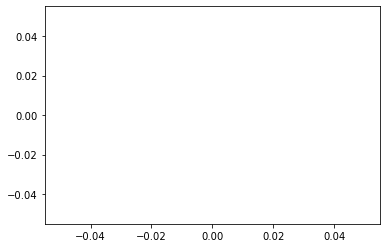

In [103]:
from tqdm import tqdm

# Import packages needed to read and print our data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Declare PATH_to_Dataset
#ROOT_PATH = "C:/Users/USER/Desktop/Datasets/Kaggle_Digit_Recognizer/"

# List the files in the ROOT_PATH
#print(f"In the Root Path, there are {os.listdir(ROOT_PATH)}")

# Store the file names in the ROOT_PATH
#CSV_TEST = ROOT_PATH + "test.csv"
#CSV_TRAIN= ROOT_PATH + "train.csv"

# Initialize Parameters
K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8 = Initialize_Parameters(-0.1, 0.1)

# Read CSV File Through Pandas
#DF_TRAIN = pd.read_csv(CSV_TRAIN)
#DF_TRAIN_NO_LABLE = DF_TRAIN.drop(columns=["label"], axis=0)
Epoch = 1
loss_list = []

i = 1
lr = 1
for epoch in range(Epoch):
    tmp_list = []
    tic = time.time()
    #for i in tqdm(range(len(X_train))):
    for i in tqdm(range(5000)):   
        # 1. Pick one example
        X, Y_truth = X_train[i], Y_train[i]
    
        # 2. Forward Pass
        #cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred = LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, "avgpooling", "sigmoid")
        cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, Y_pred = LeNet5_forward(X, K_C1, b_C1, hparam_C1, hparam_S2, K_C3, b_C3, hparam_C3, hparam_S4, K_C5, b_C5, hparam_C5, W7, W8, "avgpooling", "sigmoid")
    
        # 3. Cross Entropy Loss
        tmp_list.append(cross_entropy(Y_pred, Y_truth))
        
        # 4. Backward Pass
        #D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1 = LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, X_A8, Y_pred, Y_truth, "avgpooling", "sigmoid")
        D_W8, D_W7, D_K_C5, D_b_C5, D_K_C3, D_b_C3, D_K_C1, D_b_C1 = LeNet5_backward(cache_C1, X_A1, cache_S2, cache_C3, X_A3, cache_S4, cache_C5, X_A5, X_A6, X_A7, Y_pred, Y_truth, "avgpooling", "sigmoid")

        # 5. Update Weights
        W8, W7, K_C5, b_C5, K_C3, b_C3, K_C1, b_C1 = update_trainable_parameters(lr, D_W8, W8, D_W7, W7, D_K_C5, K_C5, D_b_C5, b_C5, D_K_C3, K_C3, D_b_C3, b_C3, D_K_C1, K_C1, D_b_C1, b_C1)
        
        if i % 100 == 0:
            print(f"[{round(cross_entropy(Y_pred, Y_truth),6)}]")
            print(f"[{Y_pred}]")
    
    toc = time.time()
    
plt.plot(loss_list)

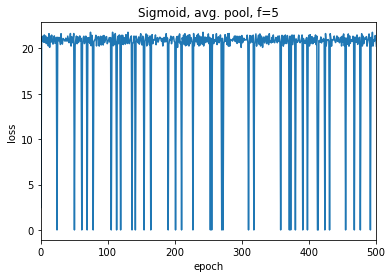

In [104]:
import matplotlib

plt.title("Sigmoid, avg. pool, f=5")
plt.plot(tmp_list)
plt.ylabel('loss')
plt.xlabel("epoch")
#plt.ylim(2.2, 2.2)
plt.xlim(0,500)
plt.show()

In [ ]:
X_train_tmp, Y_train_tmp, X_test_tmp, Y_test_tmp = load()

X_test = np.zeros((len(X_test_tmp), 28, 28, 1))
Y_test = np.zeros((len(Y_test_tmp), 10))

    

In [90]:
import pandas as pd
import os
import collections

# Declare PATH_to_Dataset
ROOT_PATH = "C:/Users/USER/Desktop/Datasets/Kaggle_Digit_Recognizer/"

# List the files in the ROOT_PATH
print(f"In the Root Path, there are {os.listdir(ROOT_PATH)}")

# Store the file names in the ROOT_PATH
CSV_TEST = ROOT_PATH + "test.csv"
CSV_TRAIN= ROOT_PATH + "train.csv"

DF_TRAIN = pd.read_csv(CSV_TRAIN)

print(collections.Counter(DF_TRAIN["label"][:50]))

In the Root Path, there are ['sample_submission.csv', 'test.csv', 'train.csv']
Counter({1: 8, 3: 7, 4: 6, 9: 6, 0: 5, 7: 5, 2: 5, 8: 3, 6: 3, 5: 2})
